# Diabetes Prediction with Python Object-Oriented Programming (OOP)
This notebook explores the diabetes prediction dataset, performing exploratory data analysis (EDA) to understand the data distribution, relationships, and potential predictive features.

In [25]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import os
import joblib

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import (accuracy_score, confusion_matrix, classification_report,
                           roc_curve, auc, precision_recall_curve, f1_score)

import warnings
warnings.filterwarnings("ignore")

## Dataset Overview
The dataset contains various health-related attributes of patients, along with a target variable indicating whether the patient has diabetes. The goal is to build a predictive model to classify patients based on these attributes.

In [31]:
# Enhanced Dataset Management Class

class DiabetesDataset:
    def __init__(self, file_path):
        self.file_path = file_path
        self.data = None
        self.features = None
        self.target = None
        self.numerical_features = []
        self.categorical_features = []
        self.load_data()

    def load_data(self):
        """Load and perform initial data checks"""
        try:
            self.data = pd.read_csv(self.file_path)
            print(f"Dataset loaded successfully with {self.data.shape[0]} rows and {self.data.shape[1]} columns")
        except Exception as e:
            raise Exception(f"Error loading dataset: {str(e)}")

    def perform_eda(self):
        """Comprehensive Exploratory Data Analysis"""
        self._analyze_data_structure()
        self._analyze_missing_values()
        self._analyze_feature_distributions()
        self._analyze_correlations()
        self._analyze_target_distribution()

    def _analyze_data_structure(self):
        """Analyze data structure and feature types"""
        print("\nData Structure Analysis:")
        print(self.data.info())
        print("\nSummary Statistics:")
        print(self.data.describe())

        self.numerical_features = self.data.select_dtypes(include=['int64', 'float64']).columns
        self.categorical_features = self.data.select_dtypes(include=['object']).columns

    def _analyze_missing_values(self):
        """Analyze missing values"""
        missing = self.data.isnull().sum()
        if missing.any():
            print("\nMissing Values Analysis:")
            print(missing[missing > 0])

    def _analyze_feature_distributions(self):
        """Analyze feature distributions"""
        # Numerical features distributions
        plt.figure(figsize=(15, 10))
        for i, feature in enumerate(self.numerical_features):
            plt.subplot(3, 3, i+1)
            sns.histplot(self.data[feature], kde=True)
            plt.title(f'Distribution of {feature}')
            plt.xlabel(feature)
        plt.tight_layout()
        plt.show()

        # Categorical features distributions
        plt.figure(figsize=(12, 5))
        for i, feature in enumerate(self.categorical_features):
            plt.subplot(1, len(self.categorical_features), i+1)
            sns.countplot(data=self.data, y=feature)
            plt.title(f'Distribution of {feature}')
        plt.tight_layout()
        plt.show()

    def _analyze_correlations(self):
        """Analyze feature correlations with encoding"""
        # Create a copy of the data for encoding
        data_encoded = self.data.copy()
        
        # Encode categorical columns
        for column in data_encoded.select_dtypes(include=['object']):
            data_encoded[column] = pd.Categorical(data_encoded[column]).codes
        
        plt.figure(figsize=(12, 8))
        sns.heatmap(data_encoded.corr(), annot=True, fmt='.2f', cmap='coolwarm')
        plt.title('Feature Correlations (with encoded categorical variables)')
        plt.show()

    def _analyze_target_distribution(self):
        """Analyze target variable distribution"""
        plt.figure(figsize=(10, 5))
        sns.countplot(data=self.data, x='diabetes')
        plt.title('Distribution of Diabetes Cases')
        plt.show()

    def prepare_data(self):
        """Prepare data for modeling"""
        # Encode categorical variables
        le = LabelEncoder()
        for col in self.categorical_features:
            self.data[col] = le.fit_transform(self.data[col])

        # Separate features and target
        self.features = self.data.drop('diabetes', axis=1)
        self.target = self.data['diabetes']

        return self.features, self.target

## Class for the Decision Tree Model
This class encapsulates the functionality of a Decision Tree Classifier for diabetes prediction. It includes methods for training the model, making predictions, evaluating performance, and visualizing results.

In [27]:
# Enhanced Model Class

class DiabetesModel:
    def __init__(self, max_depth=5):
        self.model = None
        self.max_depth = max_depth
        self.pipeline = None
        self.best_params = None
        self.feature_names = None
        
    def create_pipeline(self, numerical_features, categorical_features):
        """Create preprocessing and model pipeline"""
        numeric_transformer = StandardScaler()
        
        preprocessor = ColumnTransformer(
            transformers=[
                ('num', numeric_transformer, numerical_features)
            ])
        
        self.pipeline = Pipeline([
            ('preprocessor', preprocessor),
            ('classifier', DecisionTreeClassifier(max_depth=self.max_depth, random_state=42))
        ])
        
        # Store feature names for visualization
        self.feature_names = list(numerical_features)
        
    def visualize_decision_tree(self, class_names=['No Diabetes', 'Diabetes']):
        """
        Visualize the decision tree structure
        """
        if not hasattr(self.pipeline, 'named_steps'):
            raise ValueError("Model not trained. Train the model first.")
            
        tree_classifier = self.pipeline.named_steps['classifier']
        
        plt.figure(figsize=(20,10))
        plot_tree(tree_classifier, 
                 feature_names=self.feature_names,
                 class_names=class_names,
                 filled=True,
                 rounded=True,
                 fontsize=10)
        plt.title("Decision Tree Visualization")
        plt.show()
        
    def plot_feature_importance(self):
        """
        Plot feature importance
        """
        if not hasattr(self.pipeline, 'named_steps'):
            raise ValueError("Model not trained. Train the model first.")
            
        tree_classifier = self.pipeline.named_steps['classifier']
        importances = tree_classifier.feature_importances_
        indices = np.argsort(importances)[::-1]
        
        plt.figure(figsize=(12,6))
        plt.title("Feature Importances")
        plt.bar(range(len(importances)), 
                importances[indices],
                align='center')
        plt.xticks(range(len(importances)), 
                   [self.feature_names[i] for i in indices], 
                   rotation=45, 
                   ha='right')
        plt.tight_layout()
        plt.show()
        
        # Print feature importance values
        print("\nFeature Importance Values:")
        for idx in indices:
            print(f"{self.feature_names[idx]}: {importances[idx]:.4f}")
            
    def plot_decision_boundaries(self, X, y, feature1_idx=0, feature2_idx=1):
        """
        Plot decision boundaries for two selected features
        """
        if not hasattr(self.pipeline, 'named_steps'):
            raise ValueError("Model not trained. Train the model first.")
            
        # Create mesh grid
        X_subset = X[:, [feature1_idx, feature2_idx]]
        x_min, x_max = X_subset[:, 0].min() - 1, X_subset[:, 0].max() + 1
        y_min, y_max = X_subset[:, 1].min() - 1, X_subset[:, 1].max() + 1
        xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                            np.arange(y_min, y_max, 0.1))
        
        # Make predictions
        Z = self.pipeline.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)
        
        # Plot decision boundary
        plt.figure(figsize=(10,8))
        plt.contourf(xx, yy, Z, alpha=0.4)
        plt.scatter(X_subset[:, 0], X_subset[:, 1], c=y, alpha=0.8)
        plt.xlabel(self.feature_names[feature1_idx])
        plt.ylabel(self.feature_names[feature2_idx])
        plt.title('Decision Boundaries')
        plt.colorbar()
        plt.show()
        
    def plot_learning_curves(self, X, y, cv=5):
        """
        Plot learning curves to analyze model performance with varying training set sizes
        """
        
        train_sizes, train_scores, val_scores = learning_curve(
            self.pipeline, X, y, cv=cv, n_jobs=-1, 
            train_sizes=np.linspace(0.1, 1.0, 10))
        
        train_mean = np.mean(train_scores, axis=1)
        train_std = np.std(train_scores, axis=1)
        val_mean = np.mean(val_scores, axis=1)
        val_std = np.std(val_scores, axis=1)
        
        plt.figure(figsize=(10,6))
        plt.plot(train_sizes, train_mean, label='Training score')
        plt.plot(train_sizes, val_mean, label='Cross-validation score')
        
        plt.fill_between(train_sizes, train_mean - train_std,
                         train_mean + train_std, alpha=0.1)
        plt.fill_between(train_sizes, val_mean - val_std,
                         val_mean + val_std, alpha=0.1)
        
        plt.xlabel('Training Examples')
        plt.ylabel('Score')
        plt.title('Learning Curves')
        plt.legend(loc='best')
        plt.grid(True)
        plt.show()

    def train_with_cv(self, X, y):
        """Train model with cross-validation"""
        # Perform grid search for hyperparameter tuning
        param_grid = {
            'classifier__max_depth': [3, 5, 7, 10],
            'classifier__min_samples_split': [2, 5, 10],
            'classifier__min_samples_leaf': [1, 2, 4]
        }

        grid_search = GridSearchCV(self.pipeline, param_grid, cv=5, scoring='f1')
        grid_search.fit(X, y)

        self.best_params = grid_search.best_params_
        self.pipeline = grid_search.best_estimator_

        print("\nBest parameters:", self.best_params)
        print("Cross-validation score:", grid_search.best_score_)

    def evaluate(self, X_test, y_test):
        """Evaluate model performance"""
        y_pred = self.pipeline.predict(X_test)
        y_pred_proba = self.pipeline.predict_proba(X_test)[:, 1]

        # Calculate metrics
        metrics = {
            'accuracy': accuracy_score(y_test, y_pred),
            'confusion_matrix': confusion_matrix(y_test, y_pred),
            'classification_report': classification_report(y_test, y_pred)
        }

        # Plot confusion matrix
        plt.figure(figsize=(8, 6))
        sns.heatmap(metrics['confusion_matrix'], annot=True, fmt='d',
                   xticklabels=['No Diabetes', 'Diabetes'],
                   yticklabels=['No Diabetes', 'Diabetes'])
        plt.title('Confusion Matrix')
        plt.show()

        # Plot ROC curve
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        roc_auc = auc(fpr, tpr)

        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve')
        plt.legend()
        plt.show()

        return metrics

    def save_model(self, filename):
        joblib.dump(self.model, filename)
        print(f"Model saved to {filename}")

    def load_model(self, filename):
        if os.path.exists(filename):
            self.model = joblib.load(filename)
            print(f"Model loaded from {filename}")
        else:
            raise FileNotFoundError(f"No model found at {filename}")

## Application Class
This class serves as the main application for diabetes prediction, integrating the dataset management and model functionalities.
It prepares the data, trains the model, makes predictions, evaluates performance, and visualizes results.
It can be executed to run the entire diabetes prediction workflow.
This class is designed to be reusable and modular, allowing for easy integration into larger applications or systems.
It encapsulates the entire workflow from data preparation to model evaluation, making it easy to use and extend.
It can be instantiated with a dataset path, and the `run` method can be called to execute the entire process.

This design follows the principles of object-oriented programming (OOP), promoting code reusability, modularity, and separation of concerns.

In [28]:
# Class for the Application

class DiabetesPredictionApp:
    def __init__(self, data_path):
        self.dataset = DiabetesDataset(data_path)
        self.model = DiabetesModel()
        
    def run(self):
        """Execute the complete workflow"""
        # Perform EDA
        print("Performing Exploratory Data Analysis...")
        self.dataset.perform_eda()
        
        # Prepare data
        print("\nPreparing data for modeling...")
        X, y = self.dataset.prepare_data()
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        
        # Create and train model
        print("\nTraining model with cross-validation...")
        self.model.create_pipeline(self.dataset.numerical_features, 
                                 self.dataset.categorical_features)
        self.model.train_with_cv(X_train, y_train)
        
        # Evaluate model
        print("\nEvaluating model performance...")
        metrics = self.model.evaluate(X_test, y_test)
        print("\nClassification Report:")
        print(metrics['classification_report'])
        
        # Visualize model
        print("\nGenerating model visualizations...")
        self.model.visualize_decision_tree()
        self.model.plot_feature_importance()
        self.model.plot_learning_curves(X, y)
        
        # Plot decision boundaries for the two most important features
        if len(self.dataset.numerical_features) >= 2:
            self.model.plot_decision_boundaries(X, y)

## Execution of the Application
This section runs the entire diabetes prediction application, which includes data preparation, model training, evaluation, and visualization.

Dataset loaded successfully with 100000 rows and 9 columns
Performing Exploratory Data Analysis...

Data Structure Analysis:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   gender               100000 non-null  object 
 1   age                  100000 non-null  float64
 2   hypertension         100000 non-null  int64  
 3   heart_disease        100000 non-null  int64  
 4   smoking_history      100000 non-null  object 
 5   bmi                  100000 non-null  float64
 6   HbA1c_level          100000 non-null  float64
 7   blood_glucose_level  100000 non-null  int64  
 8   diabetes             100000 non-null  int64  
dtypes: float64(3), int64(4), object(2)
memory usage: 6.9+ MB
None

Summary Statistics:
                 age  hypertension  heart_disease            bmi  \
count  100000.000000  100000.00000  100000.000000

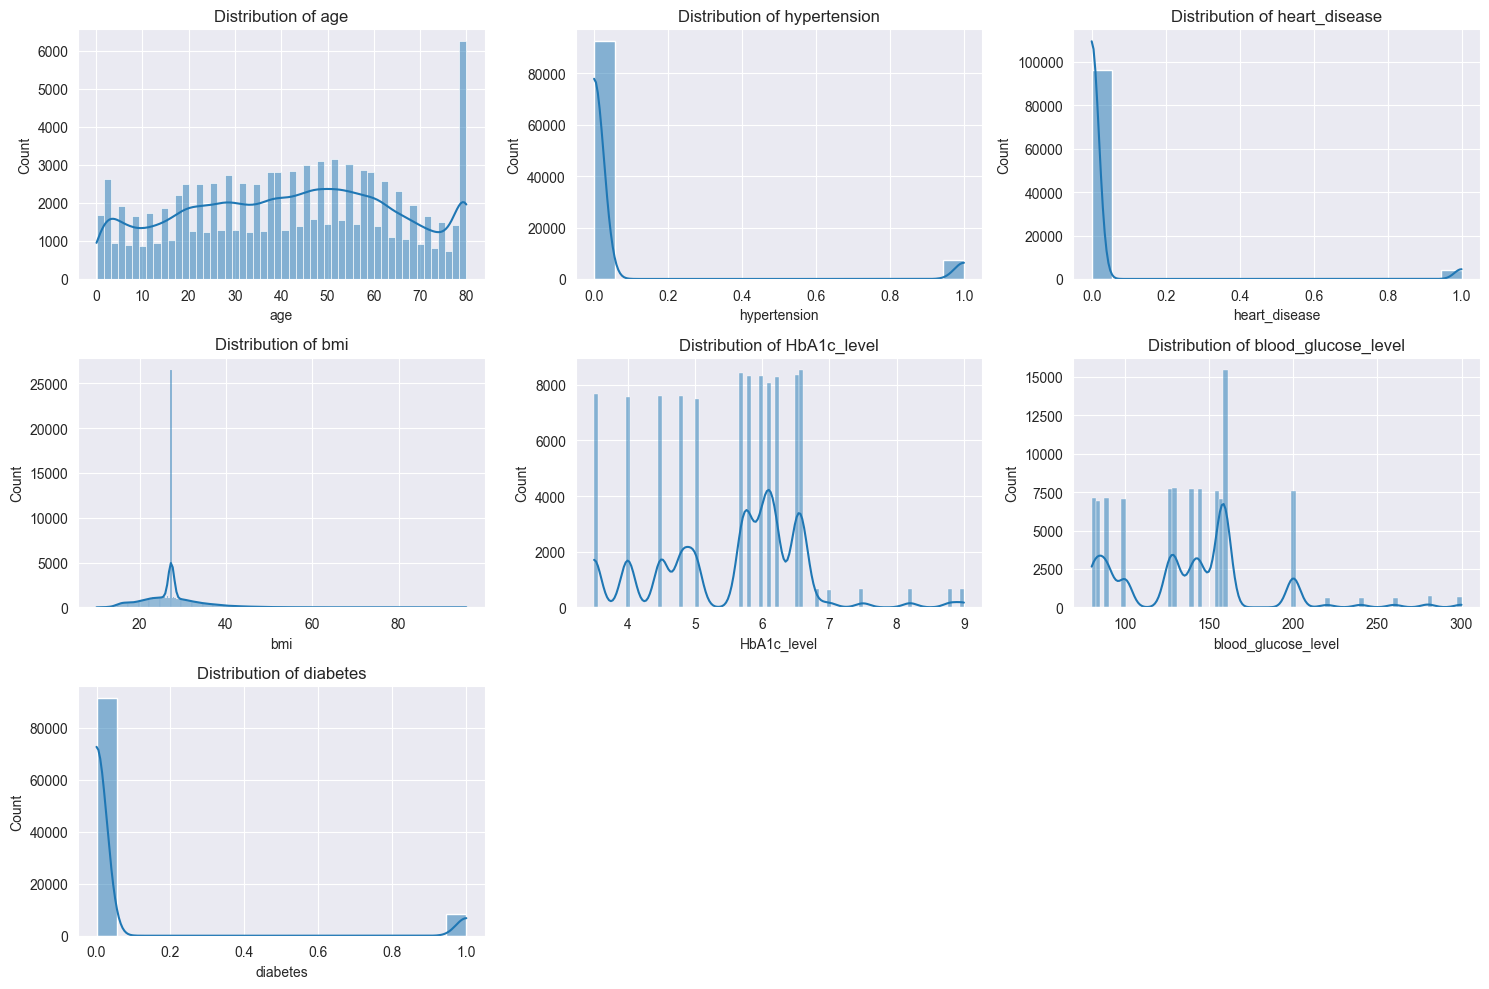

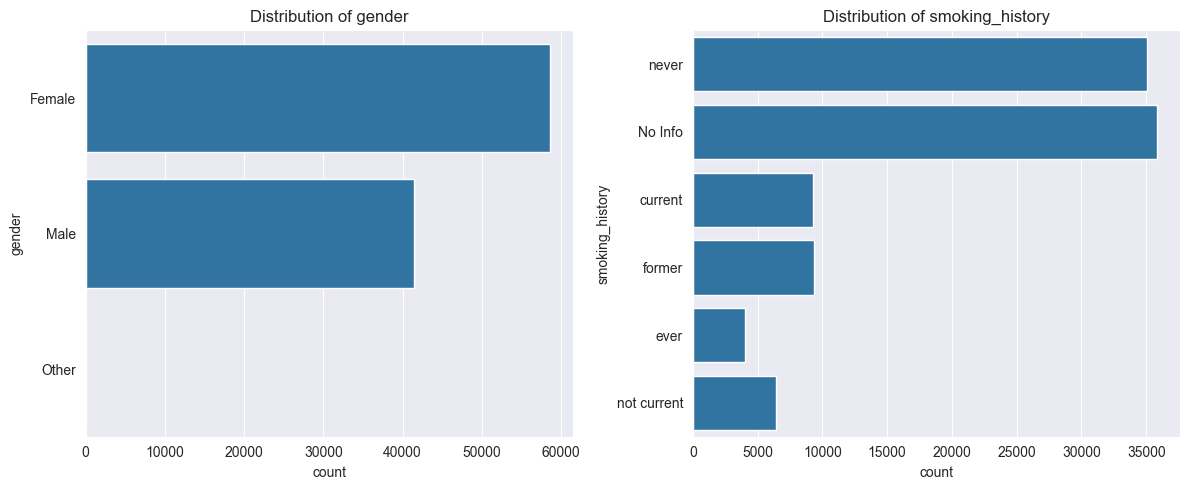

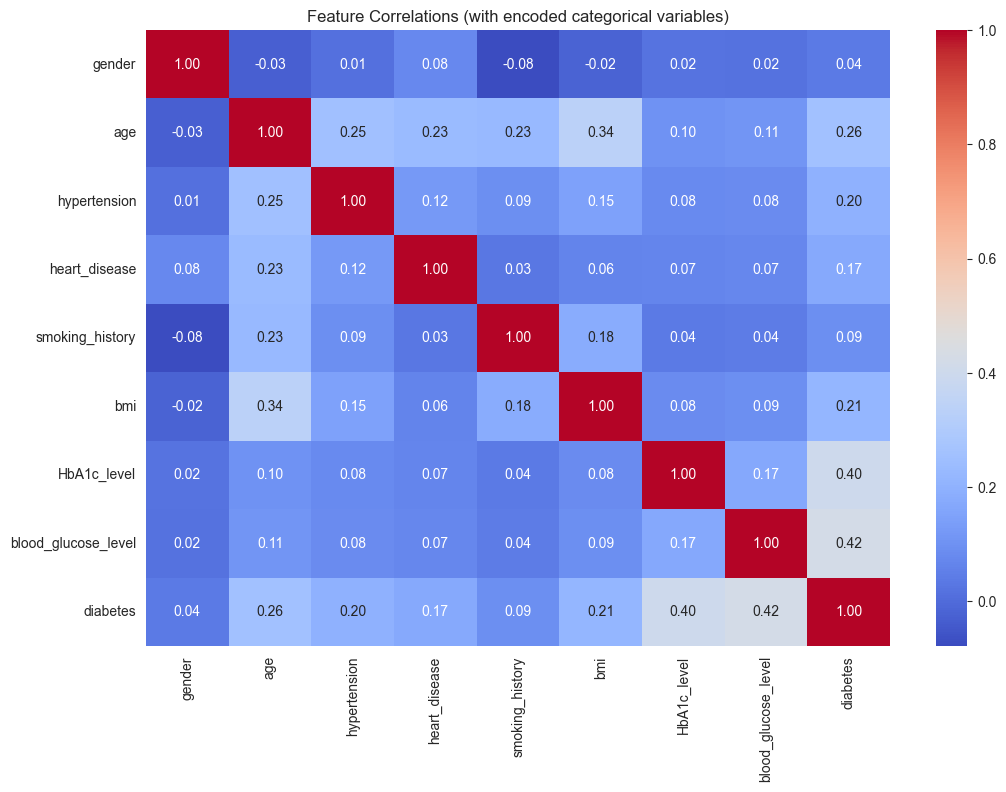

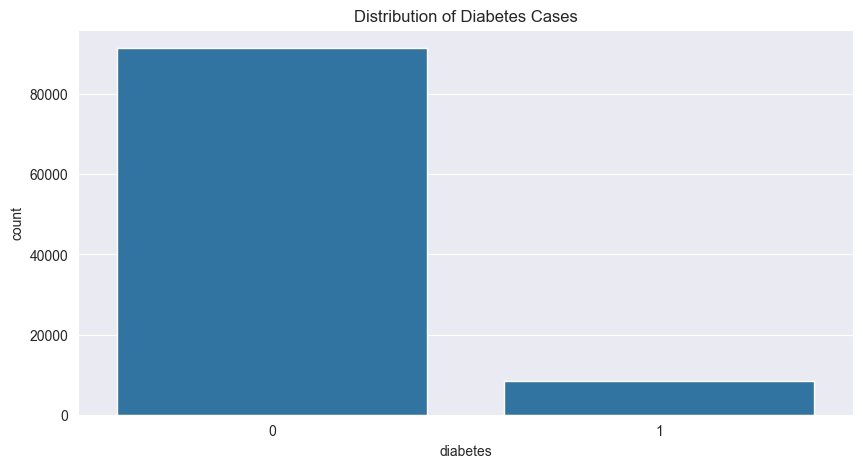


Preparing data for modeling...

Training model with cross-validation...


ValueError: 
All the 180 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
180 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\lgeov\OneDrive\Documents\Data Analytics Projects\office-hours-bootcamp\.venv\Lib\site-packages\pandas\core\indexes\base.py", line 3805, in get_loc
    return self._engine.get_loc(casted_key)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "index.pyx", line 167, in pandas._libs.index.IndexEngine.get_loc
  File "index.pyx", line 196, in pandas._libs.index.IndexEngine.get_loc
  File "pandas\\_libs\\hashtable_class_helper.pxi", line 7081, in pandas._libs.hashtable.PyObjectHashTable.get_item
  File "pandas\\_libs\\hashtable_class_helper.pxi", line 7089, in pandas._libs.hashtable.PyObjectHashTable.get_item
KeyError: 'diabetes'

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "C:\Users\lgeov\OneDrive\Documents\Data Analytics Projects\office-hours-bootcamp\.venv\Lib\site-packages\sklearn\utils\_indexing.py", line 431, in _get_column_indices
    col_idx = all_columns.get_loc(col)
              ^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\lgeov\OneDrive\Documents\Data Analytics Projects\office-hours-bootcamp\.venv\Lib\site-packages\pandas\core\indexes\base.py", line 3812, in get_loc
    raise KeyError(key) from err
KeyError: 'diabetes'

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "C:\Users\lgeov\OneDrive\Documents\Data Analytics Projects\office-hours-bootcamp\.venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\lgeov\OneDrive\Documents\Data Analytics Projects\office-hours-bootcamp\.venv\Lib\site-packages\sklearn\base.py", line 1363, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\lgeov\OneDrive\Documents\Data Analytics Projects\office-hours-bootcamp\.venv\Lib\site-packages\sklearn\pipeline.py", line 653, in fit
    Xt = self._fit(X, y, routed_params, raw_params=params)
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\lgeov\OneDrive\Documents\Data Analytics Projects\office-hours-bootcamp\.venv\Lib\site-packages\sklearn\pipeline.py", line 587, in _fit
    X, fitted_transformer = fit_transform_one_cached(
                            ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\lgeov\OneDrive\Documents\Data Analytics Projects\office-hours-bootcamp\.venv\Lib\site-packages\joblib\memory.py", line 326, in __call__
    return self.func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\lgeov\OneDrive\Documents\Data Analytics Projects\office-hours-bootcamp\.venv\Lib\site-packages\sklearn\pipeline.py", line 1539, in _fit_transform_one
    res = transformer.fit_transform(X, y, **params.get("fit_transform", {}))
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\lgeov\OneDrive\Documents\Data Analytics Projects\office-hours-bootcamp\.venv\Lib\site-packages\sklearn\utils\_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\lgeov\OneDrive\Documents\Data Analytics Projects\office-hours-bootcamp\.venv\Lib\site-packages\sklearn\base.py", line 1363, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\lgeov\OneDrive\Documents\Data Analytics Projects\office-hours-bootcamp\.venv\Lib\site-packages\sklearn\compose\_column_transformer.py", line 988, in fit_transform
    self._validate_column_callables(X)
  File "C:\Users\lgeov\OneDrive\Documents\Data Analytics Projects\office-hours-bootcamp\.venv\Lib\site-packages\sklearn\compose\_column_transformer.py", line 541, in _validate_column_callables
    transformer_to_input_indices[name] = _get_column_indices(X, columns)
                                         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\lgeov\OneDrive\Documents\Data Analytics Projects\office-hours-bootcamp\.venv\Lib\site-packages\sklearn\utils\_indexing.py", line 439, in _get_column_indices
    raise ValueError("A given column is not a column of the dataframe") from e
ValueError: A given column is not a column of the dataframe


In [32]:
# Execute the application
app = DiabetesPredictionApp('../data/diabetes_prediction_dataset.csv')
app.run()